## Библиотеки 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import *
import logging
print(tf.version.VERSION)
tf.get_logger().setLevel(logging.ERROR)
try: # detect TPU
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPU(s) and enable mixed precision
    strategy = tf.distribute.MirroredStrategy() # works on GPU and multi-GPU
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')
print("REPLICAS: ", strategy.num_replicas_in_sync)

2.6.3
Mixed precision enabled
REPLICAS:  1


In [2]:
print(strategy)

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Функции

In [4]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

## Получение данных

In [5]:
df_train = pd.read_csv('/kaggle/input/alfabankchallengedata/df_train.csv', sep=';')
df_test = pd.read_csv('/kaggle/input/alfabankchallengedata/df_test.csv', sep=';')

In [6]:
df_train['Data'] = df_train.Data.apply(lambda s: list(map(int, s.split(','))))
df_train['Target'] = df_train.Target.apply(lambda s: list(map(int, s.split(','))))
df_test['Data'] = df_test.Data.apply(lambda s: list(map(int, s.split(','))))

In [7]:
df_train['Data']

0       [4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...
1       [6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...
2       [8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...
3       [4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...
4       [4814, 4814, 4814, 4814, 4814, 4814, 5946, 481...
                              ...                        
7028    [6010, 4829, 6011, 6011, 6011, 6010, 6011, 601...
7029    [4814, 5699, 5641, 5411, 6010, 6011, 4814, 601...
7030    [6011, 6011, 6011, 6011, 6011, 6011, 6011, 601...
7031    [4814, 4814, 5411, 6011, 6011, 4814, 4814, 481...
7032    [6011, 6011, 6011, 6011, 5541, 4814, 6011, 601...
Name: Data, Length: 7033, dtype: object

In [8]:
def encode_data(data, series):
    all_data = [item for sublist in data['Data'] for item in sublist]
    unique_values = list(set(all_data))
    sorted_values = sorted(unique_values, reverse=False)

    value_to_code = {value: code + 1 for code, value in enumerate(sorted_values)}

    def encode_list(data_list):
        return [value_to_code[value] for value in data_list]

    encoded_series = data[series].apply(encode_list)

    return encoded_series, value_to_code

def decode_data(encoded_series, code_to_value):
    def decode_list(encoded_list):
        return [code_to_value[code] for code in encoded_list]
    decoded_series = encoded_series.apply(decode_list)

    return decoded_series


encoded_train_series, value_to_code = encode_data(df_train, 'Data')
encoded_target_series, _ = encode_data(df_train, 'Target')
decoded_train_series = decode_data(encoded_train_series, {code: value for value, code in value_to_code.items()})
decoded_target_series = decode_data(encoded_target_series, {code: value for value, code in value_to_code.items()})

encoded_test_series, test_value_to_code = encode_data(df_test, 'Data')
decoded_test_series = decode_data(encoded_test_series, {code: value for value, code in test_value_to_code.items()})


In [9]:
print("Закодированные последовательности:\n\n",encoded_train_series)
print("\n")
print("Раскодированные последовательности:\n\n",decoded_train_series)
print("\n")
print("Закодированные ответы:\n\n",encoded_target_series)
print("\n")
print("Раскодированные ответы:\n\n",decoded_target_series)

Закодированные последовательности:

 0       [21, 21, 124, 125, 21, 125, 125, 21, 125, 125,...
1       [125, 125, 125, 125, 125, 125, 125, 21, 21, 21...
2       [168, 125, 125, 124, 23, 21, 125, 125, 125, 12...
3       [21, 125, 21, 21, 21, 125, 125, 78, 78, 57, 57...
4       [21, 21, 21, 21, 21, 21, 104, 21, 21, 125, 21,...
                              ...                        
7028    [124, 23, 125, 125, 125, 124, 125, 125, 125, 2...
7029    [21, 80, 73, 57, 124, 125, 21, 125, 125, 50, 5...
7030    [125, 125, 125, 125, 125, 125, 125, 125, 125, ...
7031    [21, 21, 57, 125, 125, 21, 21, 21, 57, 125, 49...
7032    [125, 125, 125, 125, 66, 21, 125, 125, 66, 66,...
Name: Data, Length: 7033, dtype: object


Раскодированные последовательности:

 0       [4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...
1       [6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...
2       [8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...
3       [4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...
4       [4814

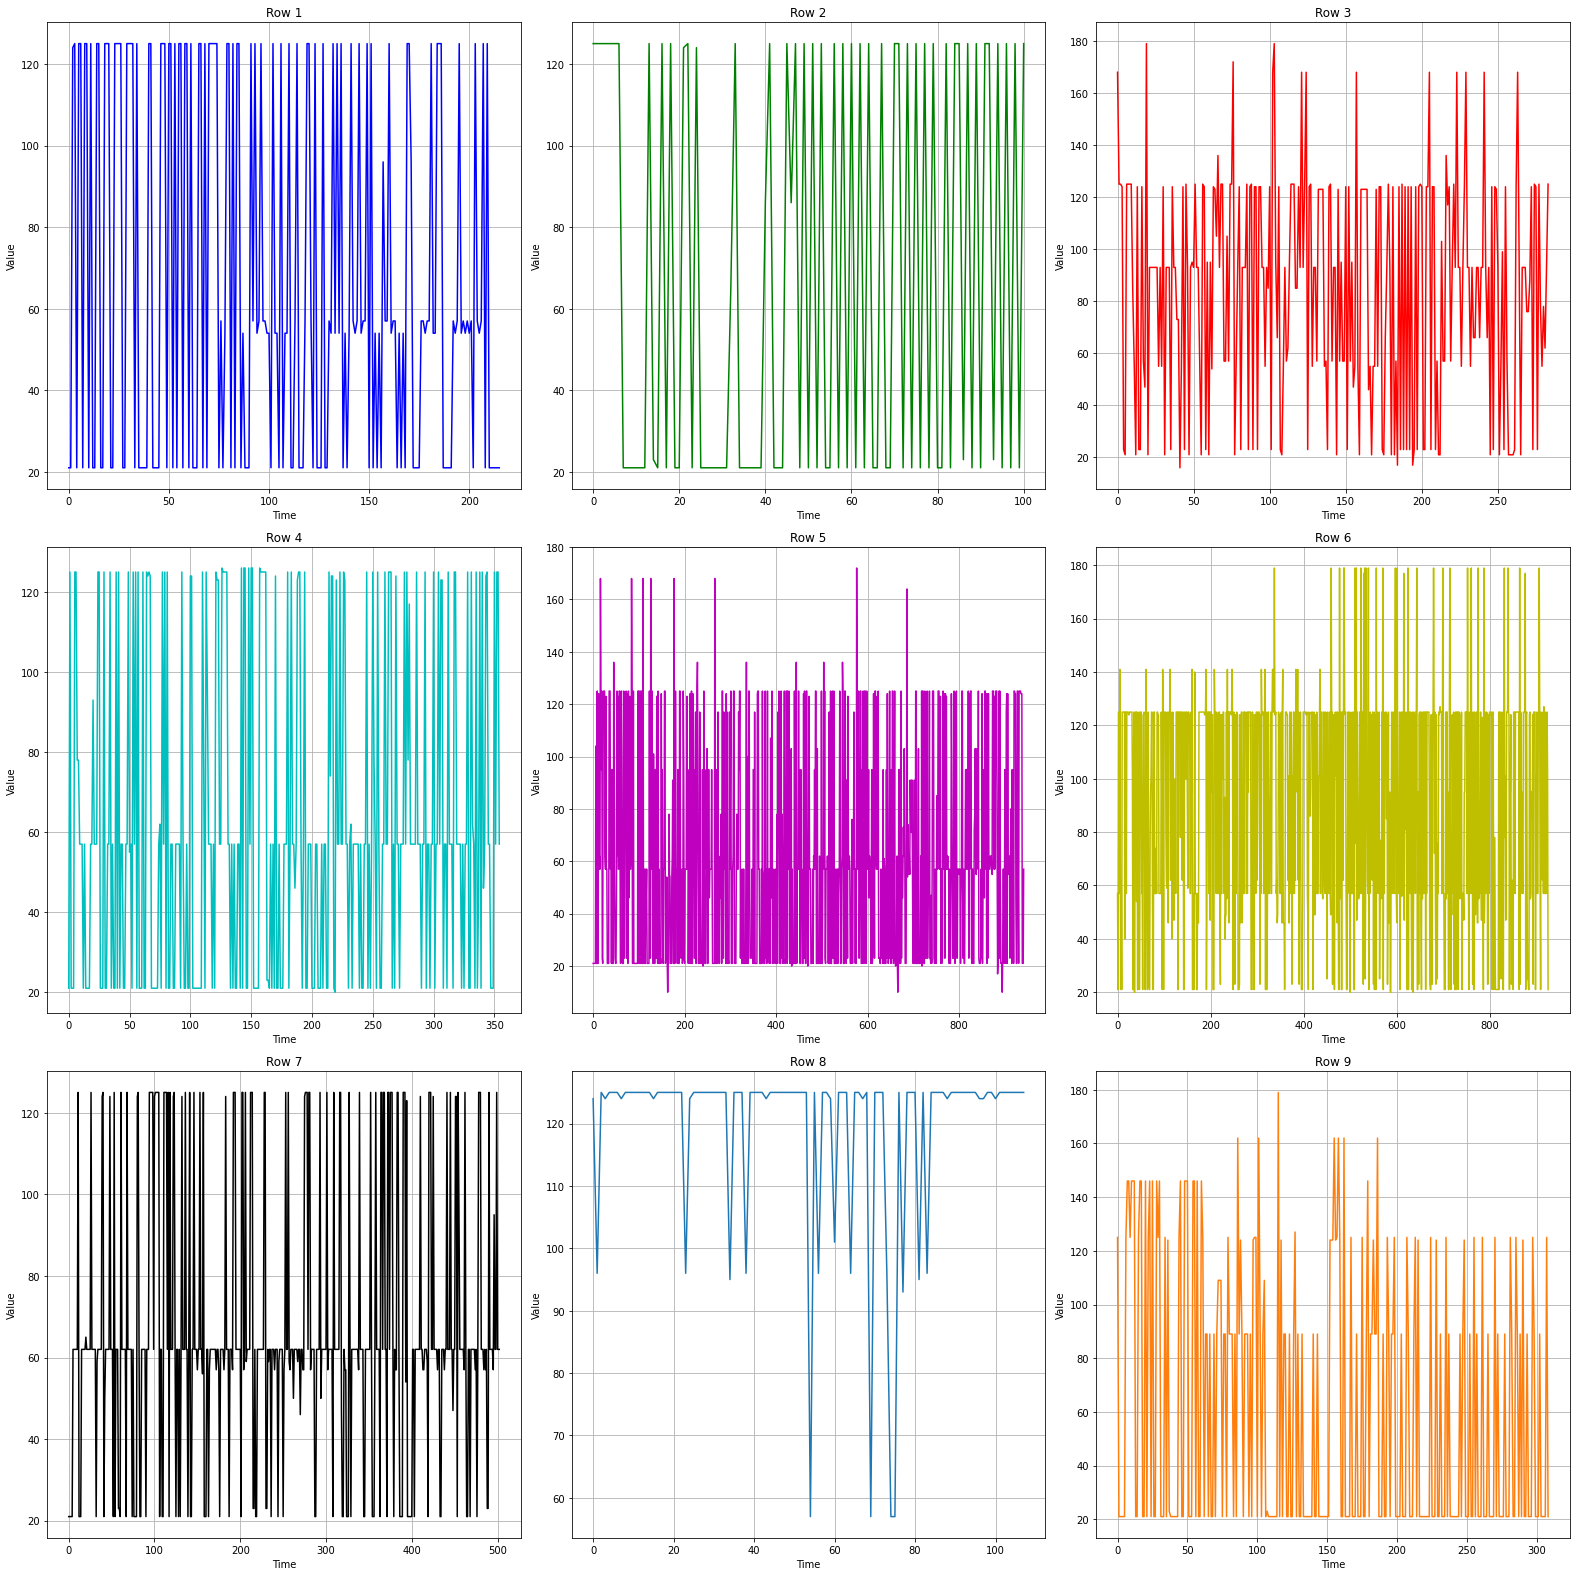

In [10]:
import matplotlib.pyplot as plt

def viz_rows(data, num_rows=9):
    plt.figure(figsize=(22, 22))
    selected_rows = data.iloc[:num_rows]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange']

    for i, (row, color) in enumerate(zip(selected_rows, colors)):
        plt.subplot(3, 3, i + 1)
        plt.plot(row, color=color)
        plt.title(f"Row {i + 1}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

viz_rows(encoded_train_series)

In [11]:
from scipy import stats

def assign_class(length, data):
    
    percentiles = data['purchase_length'].quantile([0.05, 0.15, 0.25, 0.35, 0.50, 0.65, 0.75, 0.85, 0.95])

    if length <= percentiles[0.05]:
        return 0
    elif length <= percentiles[0.15]:
        return 1
    elif length <= percentiles[0.25]:
        return 2
    elif length <= percentiles[0.35]:
        return 3
    elif length <= percentiles[0.50]:
        return 4
    elif length <= percentiles[0.65]:
        return 5
    elif length <= percentiles[0.75]:
        return 6
    elif length <= percentiles[0.85]:
        return 7
    elif length <= percentiles[0.95]:
        return 8
    else:
        return 9

def get_top_codes(purchase_history, top_n=0.1):
    total_count = len(purchase_history)
    counts = Counter(purchase_history)
    top_codes = [code for code, count in counts.items() if count / total_count >= top_n]
    top_codes = sorted(top_codes, key=lambda x: counts[x], reverse=True)[:3]
    
    return top_codes

def get_top_n(purchase_history, top=0.4, n=30):
    if len(purchase_history) > n:
        purchase_history = purchase_history[-n:]
    counts = Counter(purchase_history)
    sorted_codes = sorted(counts, key=lambda x: counts[x], reverse=True)
    top_codes = [code for code in sorted_codes if counts[code] / len(purchase_history) >= top]
    
    if len(top_codes) < 1:
        top_codes = [code for code in sorted_codes if counts[code] / len(purchase_history) >= 0.1]
    
    return top_codes


def count_top_codes(purchase_history, top_codes):
    count = sum(1 for code in purchase_history if code in top_codes)
    return count

def desc_data(data):
    data['Data Availability'] = data['purchase_history'].apply(lambda x: 'Insufficient' if len(x) < 8 else 'Sufficient')
    
    for stat in ['mean', 'std', '25%', '50%', '75%', 'min', 'max']:
        data[stat] = data['purchase_history'].apply(lambda x: pd.Series(x).describe()[stat] if len(x) >= 8 else None)
    
    data['Is Normally Distributed'] = data['purchase_history'].apply(lambda x: stats.normaltest(x)[1] >= 0.05 if len(x) >= 8 else None)
    data['p-value'] = data['purchase_history'].apply(lambda x: stats.normaltest(x)[1] if len(x) >= 8 else None)

    return data

def set_features(data, column):
    tqdm_notebook.pandas()
    data = pd.DataFrame({'purchase_history': data[column]})
    data['id'] = range(1, len(data) + 1)
    data['purchase_length'] = data['purchase_history'].progress_apply(len)
    data['top_codes'] = data['purchase_history'].progress_apply(get_top_n)
    data['top_length'] = data['top_codes'].progress_apply(len)
    data['unique_codes'] = data['purchase_history'].progress_apply(lambda x: list(set(x)))
    data['unique_length'] = data['unique_codes'].progress_apply(len)
    data['count_top_codes'] = data.progress_apply(lambda row: count_top_codes(row['purchase_history'], row['top_codes']), axis=1)
    data['top_ratio'] = data['top_length'] / data['unique_length']
    data['count_top_ratio'] = data['count_top_codes'] / data['top_length']
    data['top_density'] = data['unique_length'] / data['count_top_codes']
    data['unique_density'] = data['unique_length'] / data['purchase_length']
    data['purchase_ratio'] = data['count_top_codes'] / data['purchase_length']
    data['length_class'] = data.progress_apply(lambda row: assign_class(row['purchase_length'], data), axis=1)
    
    return desc_data(data)


In [12]:
train = pd.DataFrame(encoded_train_series)
target = pd.DataFrame(encoded_target_series)
test = pd.DataFrame(encoded_test_series)
print("Set features in train:")
ft_train = set_features(train, 'Data')
print("Set features in target:")
ft_target = set_features(target, 'Target')
print("Set features in test:")
ft_test = set_features(test, 'Data')

ft_target

Set features in train:


  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

Set features in target:


  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

Set features in test:


  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

  0%|          | 0/7033 [00:00<?, ?it/s]

,purchase_history,id,purchase_length,top_codes,top_length,unique_codes,unique_length,count_top_codes,top_ratio,count_top_ratio,...,Data Availability,mean,std,25%,50%,75%,min,max,Is Normally Distributed,p-value
0,"[21, 21, 21, 21, 57, 21, 21, 21, 21, 21]",1,10,[21],1,"[57, 21]",2,9,0.500000,9.000000,...,Sufficient,24.6,11.384200,21.00,21.0,21.00,21.0,57.0,False,6.297571e-07
1,"[21, 125, 21, 125, 21, 21, 125, 21, 125, 21]",2,10,"[21, 125]",2,"[125, 21]",2,10,1.000000,5.000000,...,Sufficient,62.6,53.705369,21.00,21.0,125.00,21.0,125.0,False,1.677265e-02
2,"[125, 125, 124, 23, 23, 124, 125, 125, 21, 125]",3,10,[125],1,"[21, 124, 125, 23]",4,5,0.250000,5.000000,...,Sufficient,94.0,49.459299,48.25,124.5,125.00,21.0,125.0,True,1.877423e-01
3,"[125, 125, 124, 125, 125, 21, 21, 125, 21, 21]",4,10,"[125, 21]",2,"[21, 124, 125]",3,9,0.666667,4.500000,...,Sufficient,83.3,53.620166,21.00,124.5,125.00,21.0,125.0,False,1.678428e-02
4,"[62, 125, 21, 23, 46, 57, 62, 95, 57, 95]",5,10,"[62, 57, 95, 125, 21, 23, 46]",7,"[46, 21, 23, 57, 125, 62, 95]",7,10,1.000000,1.428571,...,Sufficient,64.3,32.663435,48.75,59.5,86.75,21.0,125.0,True,7.606201e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,"[21, 62, 62, 57, 49, 21, 62, 62, 49, 62]",7029,10,[62],1,"[57, 21, 62, 49]",4,5,0.250000,5.000000,...,Sufficient,50.7,16.492759,49.00,59.5,62.00,21.0,62.0,True,1.146413e-01
7029,"[125, 50, 125, 50, 21, 57, 21, 125, 57, 21]",7030,10,"[125, 21, 50, 57]",4,"[57, 50, 21, 125]",4,10,1.000000,2.500000,...,Sufficient,65.2,43.697953,28.25,53.5,108.00,21.0,125.0,True,3.222741e-01
7030,"[125, 125, 125, 125, 125, 125, 125, 125, 125, ...",7031,10,[125],1,[125],1,10,1.000000,10.000000,...,Sufficient,125.0,0.000000,125.00,125.0,125.00,125.0,125.0,False,0.000000e+00
7031,"[21, 125, 125, 123, 123, 125, 125, 124, 23, 125]",7032,10,[125],1,"[21, 23, 123, 124, 125]",5,5,0.200000,5.000000,...,Sufficient,103.9,43.175224,123.00,124.5,125.00,21.0,125.0,False,2.374904e-02


In [13]:
ft_train

,purchase_history,id,purchase_length,top_codes,top_length,unique_codes,unique_length,count_top_codes,top_ratio,count_top_ratio,...,Data Availability,mean,std,25%,50%,75%,min,max,Is Normally Distributed,p-value
0,"[21, 21, 124, 125, 21, 125, 125, 21, 125, 125,...",1,216,[21],1,"[96, 21, 54, 57, 124, 125]",6,81,0.166667,81.000000,...,Sufficient,67.379630,45.047617,21.0,54.0,125.0,21.0,125.0,False,0.000000e+00
1,"[125, 125, 125, 125, 125, 125, 125, 21, 21, 21...",2,101,"[125, 21]",2,"[66, 21, 86, 23, 124, 125]",6,93,0.333333,46.500000,...,Sufficient,67.049505,51.086667,21.0,21.0,125.0,21.0,125.0,False,3.792762e-193
2,"[168, 125, 125, 124, 23, 21, 125, 125, 125, 12...",3,284,"[21, 93, 23, 124, 125]",5,"[136, 16, 17, 21, 23, 168, 172, 46, 47, 179, 5...",30,180,0.166667,36.000000,...,Sufficient,84.933099,42.339522,55.0,93.0,124.0,16.0,179.0,False,1.490259e-09
3,"[21, 125, 21, 21, 21, 125, 125, 78, 78, 57, 57...",4,355,"[21, 125, 57]",3,"[74, 76, 117, 78, 46, 93, 21, 23, 55, 20, 57, ...",17,312,0.176471,104.000000,...,Sufficient,62.098592,40.127113,21.0,57.0,120.0,20.0,126.0,False,1.645410e-28
4,"[21, 21, 21, 21, 21, 21, 104, 21, 21, 125, 21,...",5,942,"[21, 125, 124, 57]",4,"[136, 10, 17, 20, 21, 23, 25, 164, 168, 172, 4...",37,644,0.108108,161.000000,...,Sufficient,60.352442,40.854437,21.0,57.0,95.0,10.0,172.0,False,4.495815e-46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,"[124, 23, 125, 125, 125, 124, 125, 125, 125, 2...",7029,664,[49],1,"[65, 76, 47, 49, 119, 21, 55, 23, 57, 124, 125...",13,462,0.076923,462.000000,...,Sufficient,52.539157,24.054080,49.0,49.0,49.0,21.0,125.0,False,3.979037e-57
7029,"[21, 80, 73, 57, 124, 125, 21, 125, 125, 50, 5...",7030,586,"[125, 21, 57]",3,"[21, 23, 25, 169, 170, 46, 50, 57, 62, 72, 73,...",27,376,0.111111,125.333333,...,Sufficient,76.235495,42.372251,25.0,67.0,125.0,21.0,170.0,False,0.000000e+00
7030,"[125, 125, 125, 125, 125, 125, 125, 125, 125, ...",7031,53,[125],1,"[46, 57, 124, 125, 95]",5,48,0.200000,48.000000,...,Sufficient,121.622642,14.651367,125.0,125.0,125.0,46.0,125.0,False,1.659198e-18
7031,"[21, 21, 57, 125, 125, 21, 21, 21, 57, 125, 49...",7032,204,[123],1,"[65, 66, 132, 100, 91, 47, 49, 21, 118, 23, 57...",15,16,0.066667,16.000000,...,Sufficient,92.931373,39.532679,62.0,123.0,125.0,21.0,132.0,False,3.024964e-18


In [14]:
encoded_target_series

0                [21, 21, 21, 21, 57, 21, 21, 21, 21, 21]
1            [21, 125, 21, 125, 21, 21, 125, 21, 125, 21]
2         [125, 125, 124, 23, 23, 124, 125, 125, 21, 125]
3          [125, 125, 124, 125, 125, 21, 21, 125, 21, 21]
4               [62, 125, 21, 23, 46, 57, 62, 95, 57, 95]
                              ...                        
7028             [21, 62, 62, 57, 49, 21, 62, 62, 49, 62]
7029          [125, 50, 125, 50, 21, 57, 21, 125, 57, 21]
7030    [125, 125, 125, 125, 125, 125, 125, 125, 125, ...
7031     [21, 125, 125, 123, 123, 125, 125, 124, 23, 125]
7032       [125, 23, 124, 125, 125, 57, 125, 66, 124, 21]
Name: Target, Length: 7033, dtype: object

In [15]:
ft_target['purchase_history']

0                [21, 21, 21, 21, 57, 21, 21, 21, 21, 21]
1            [21, 125, 21, 125, 21, 21, 125, 21, 125, 21]
2         [125, 125, 124, 23, 23, 124, 125, 125, 21, 125]
3          [125, 125, 124, 125, 125, 21, 21, 125, 21, 21]
4               [62, 125, 21, 23, 46, 57, 62, 95, 57, 95]
                              ...                        
7028             [21, 62, 62, 57, 49, 21, 62, 62, 49, 62]
7029          [125, 50, 125, 50, 21, 57, 21, 125, 57, 21]
7030    [125, 125, 125, 125, 125, 125, 125, 125, 125, ...
7031     [21, 125, 125, 123, 123, 125, 125, 124, 23, 125]
7032       [125, 23, 124, 125, 125, 57, 125, 66, 124, 21]
Name: purchase_history, Length: 7033, dtype: object

In [16]:
def fill_list(lst):
    while len(lst) < 10:
        lst.extend(lst[:10 - len(lst)])
    return lst[:10]

predicted = ft_train['top_codes'].apply(fill_list)

In [17]:
mapk(encoded_target_series, predicted)

0.1887653781831231

In [18]:
predict1 = decode_data(ft_test['top_codes'], {code: value for value, code in test_value_to_code.items()})

In [19]:
predict1 = predict1.apply(fill_list)
df_predict = pd.DataFrame(predict1)
df_predict['Id'] = df_predict.index
df_predict['Predicted'] = df_predict['top_codes']
df_predict.drop('top_codes', axis=1, inplace=True)
df_predict['Predicted'] = df_predict.Predicted.astype(str).str.replace(',', '')
df_predict.to_csv('submission.csv', index=False)

In [20]:
df_predict

,Id,Predicted
0,0,[6011 6011 6011 6011 6011 6011 6011 6011 6011 ...
1,1,[6011 6011 6011 6011 6011 6011 6011 6011 6011 ...
2,2,[6010 6011 5411 6010 6011 5411 6010 6011 5411 ...
3,3,[4814 6011 5814 5309 4814 6011 5814 5309 4814 ...
4,4,[4814 4814 4814 4814 4814 4814 4814 4814 4814 ...
...,...,...
7028,7028,[5499 5411 6011 5499 5411 6011 5499 5411 6011 ...
7029,7029,[5411 5411 5411 5411 5411 5411 5411 5411 5411 ...
7030,7030,[5541 5499 4814 5541 5499 4814 5541 5499 4814 ...
7031,7031,[6011 6011 6011 6011 6011 6011 6011 6011 6011 ...


**Подход с обучением**

In [21]:
ft_target.columns

Index(['purchase_history', 'id', 'purchase_length', 'top_codes', 'top_length',
       'unique_codes', 'unique_length', 'count_top_codes', 'top_ratio',
       'count_top_ratio', 'top_density', 'unique_density', 'purchase_ratio',
       'length_class', 'Data Availability', 'mean', 'std', '25%', '50%', '75%',
       'min', 'max', 'Is Normally Distributed', 'p-value'],
      dtype='object')

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import plotly.express as px
import plotly.graph_objects as go
import random
from sklearn.cluster import OPTICS, Birch
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize, minmax_scale

In [23]:
unique_rows = len(df_train['Target'].apply(tuple).unique())
print(f"Количество уникальных рядов: {unique_rows}")

Количество уникальных рядов: 6784


In [24]:
count_records = len(ft_target[ft_target['top_ratio'] < 1])
print(f"Количество записей, где 'top_ratio' < 1: {count_records}")

Количество записей, где 'top_ratio' < 1: 4664


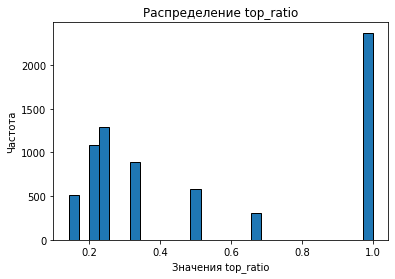

In [25]:
import matplotlib.pyplot as plt

plt.hist(ft_target['top_ratio'], bins=30, edgecolor='k')
plt.xlabel('Значения top_ratio')
plt.ylabel('Частота')
plt.title('Распределение top_ratio')
plt.show()


In [26]:
percentiles = [75, 90, 95, 99]
counts = {}
for percentile in percentiles:
    threshold = ft_train['purchase_length'].quantile(percentile / 100)
    counts[f'Свыше {percentile} перцентиля'] = len(ft_train[ft_train['purchase_length'] > threshold])

print("Количество историй пользователей:")
print(counts,"\n")
print("Всего историй пользователей:", len(ft_train['purchase_length']))

Количество историй пользователей:
{'Свыше 75 перцентиля': 1756, 'Свыше 90 перцентиля': 702, 'Свыше 95 перцентиля': 351, 'Свыше 99 перцентиля': 71} 

Всего историй пользователей: 7033


Кластеризация для тренировочных данных:



Class 0 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

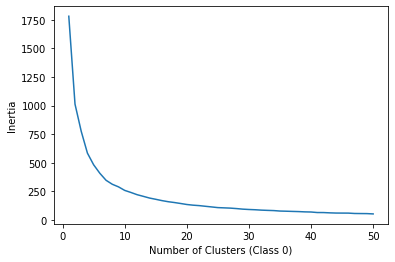

Class 1 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

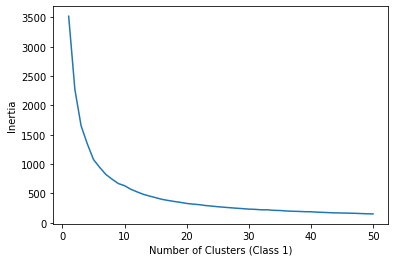

Class 2 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

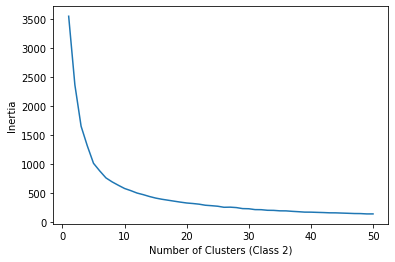

Class 3 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

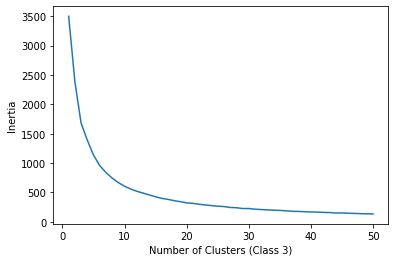

Class 4 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

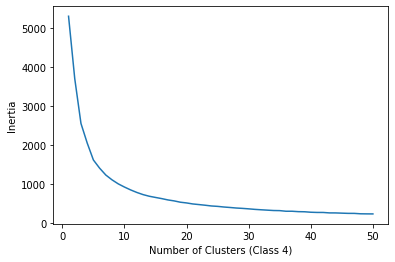

Class 5 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

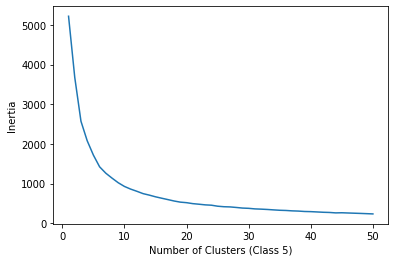

Class 6 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

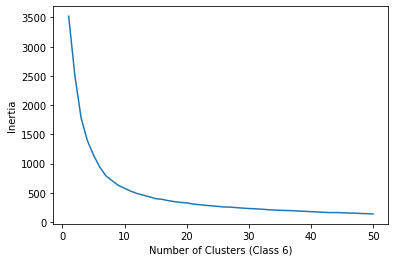

Class 7 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

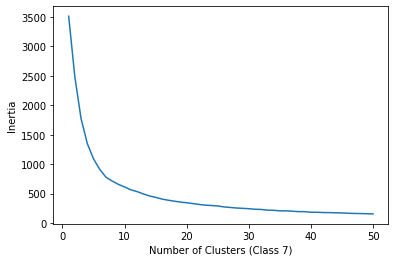

Class 8 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

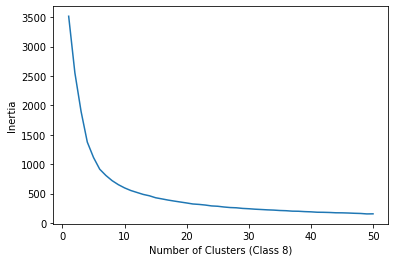

Class 9 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

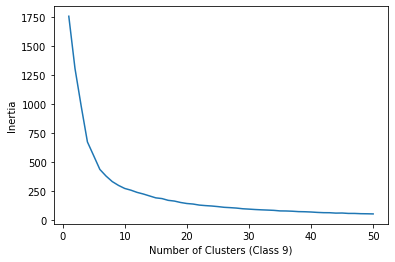

Кластеризация для тестовых данных:



Class 0 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

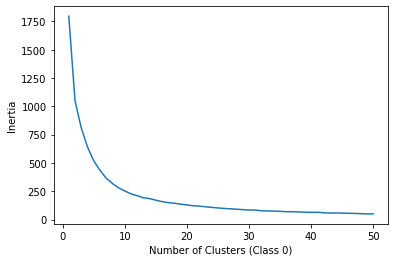

Class 1 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

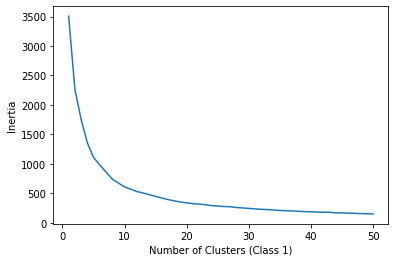

Class 2 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

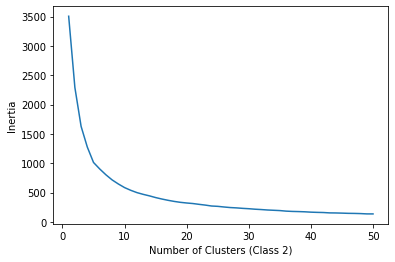

Class 3 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

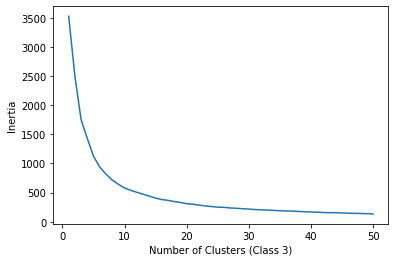

Class 4 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

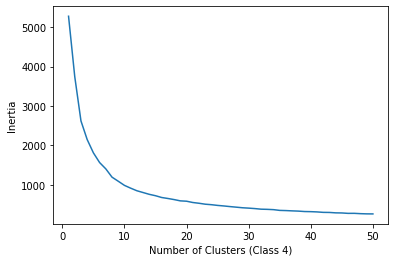

Class 5 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

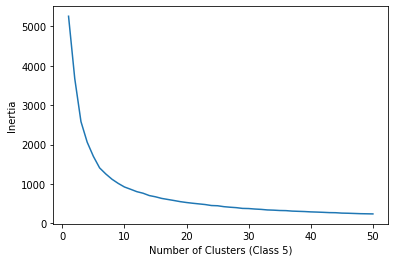

Class 6 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

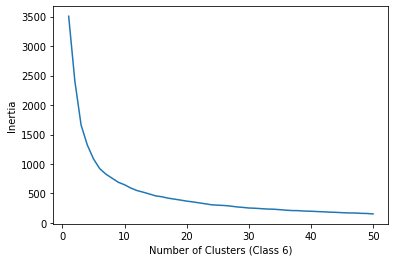

Class 7 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

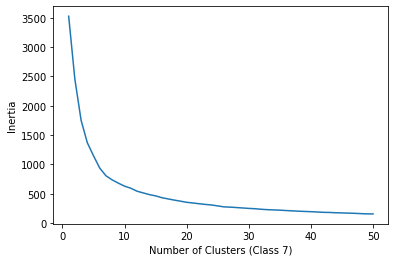

Class 8 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

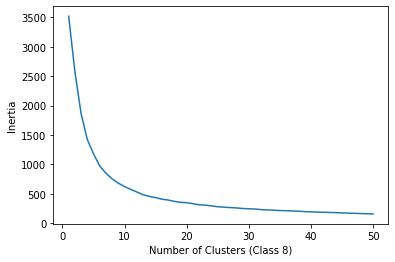

Class 9 Clusters:   0%|          | 0/50 [00:00<?, ?it/s]

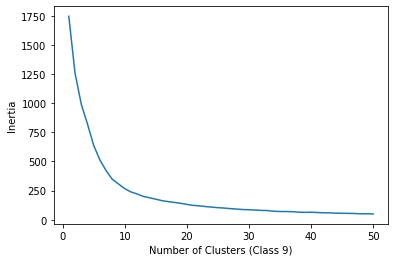

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def cluster_and_update_data(data, columns_to_include):
    data['cluster'] = 0
    for purchase_class in range(0, 10):
        class_data = data[data['length_class'] == purchase_class]
        data_scaled = StandardScaler().fit_transform(class_data[columns_to_include])
        inertia = []

        for k in tqdm_notebook(range(1, 51), desc=f'Class {purchase_class} Clusters'):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(data_scaled)
            inertia.append(kmeans.inertia_)

        plt.plot(range(1, 51), inertia)
        plt.xlabel(f'Number of Clusters (Class {purchase_class})')
        plt.ylabel('Inertia')
        plt.show()

        optimal_clusters = 6  # Здесь вы можете выбрать оптимальное количество кластеров
        kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
        kmeans.fit(data_scaled)
        data.loc[data['length_class'] == purchase_class, 'cluster'] = kmeans.labels_

print("Кластеризация для тренировочных данных:\n")
cluster_and_update_data(ft_train, columns_to_include=['top_ratio', 'count_top_ratio', 'top_density', 'unique_density', 'purchase_ratio'])
print("Кластеризация для тестовых данных:\n")
cluster_and_update_data(ft_test, columns_to_include=['top_ratio', 'count_top_ratio', 'top_density', 'unique_density', 'purchase_ratio'])

Количество данных по кластерам в тренировочном наборе
Длина истории покупок:

Класс 0: <67.0
Класс 1: <124.0
Класс 2: <180.0
Класс 3: <238.0
Класс 4: <336.0
Класс 5: <465.0
Класс 6: <570.0
Класс 7: <730.0
Класс 8: <1113.0
Класс 9: >1113.0


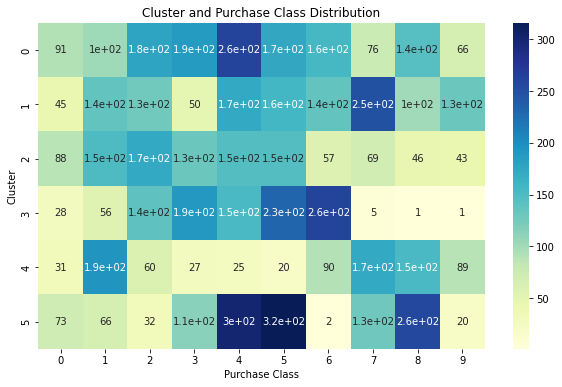

Количество данных по кластерам в тестовом наборе
Длина истории покупок:

Класс 0: <65.0
Класс 1: <121.0
Класс 2: <177.0
Класс 3: <239.0
Класс 4: <344.0
Класс 5: <472.0
Класс 6: <582.0
Класс 7: <740.0
Класс 8: <1108.0
Класс 9: >1108.0


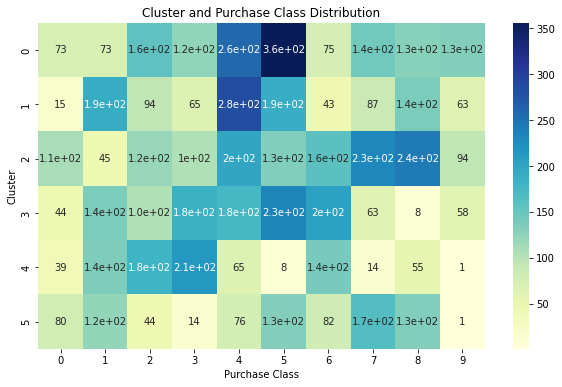

In [28]:
import seaborn as sns

def print_clusters(data):
    
    cluster_distribution = data.groupby(['cluster', 'length_class']).size().unstack()
    percentiles = data['purchase_length'].quantile([0.05, 0.15, 0.25, 0.35, 0.50, 0.65, 0.75, 0.85, 0.95])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cluster_distribution, annot=True, cmap="YlGnBu")
    plt.xlabel('Purchase Class')
    plt.ylabel('Cluster')
    plt.title('Cluster and Purchase Class Distribution')
    i = 0
    print('Длина истории покупок:\n')
    for percent in percentiles:
        print(f'Класс {i}: <{percent}')
        i+=1
        if i == 9:
            print(f'Класс 9: >{percent}')
            break
    plt.show()
    

print("Количество данных по кластерам в тренировочном наборе")
print_clusters(ft_train)
print("Количество данных по кластерам в тестовом наборе")
print_clusters(ft_test)

In [29]:
from scipy import stats

def analyze_clusters(data):
    results = []

    grouped_data = data.groupby(['cluster', 'length_class'])

    for name, group in grouped_data:
        cluster, length_class = name
        purchase_lengths = group['purchase_length']

        result = {
            'Cluster': cluster,
            'Length class': length_class,
            'Data Availability': 'Insufficient' if len(purchase_lengths) < 8 else 'Sufficient',
        }

        if len(purchase_lengths) >= 8:
            distribution = purchase_lengths.describe()
            result['Mean Purchase Length'] = distribution['mean']
            result['Standard Deviation'] = distribution['std']
            result['25%'] = distribution['25%']
            result['50%'] = distribution['50%']
            result['75%'] = distribution['75%']
            result['Min'] = distribution['min']
            result['Max'] = distribution['max']

            _, p_value = stats.normaltest(purchase_lengths)
            result['Is Normally Distributed'] = p_value >= 0.05
            result['p-value'] = p_value

        results.append(result)

    return pd.DataFrame(results)

distr_of_clusters = analyze_clusters(ft_train)

distr_of_clusters

,Cluster,Length class,Data Availability,Mean Purchase Length,Standard Deviation,25%,50%,75%,Min,Max,Is Normally Distributed,p-value
0,0,0,Sufficient,54.263736,7.932822,48.50,55.0,61.00,40.0,67.0,False,5.364936e-06
1,0,1,Sufficient,97.205882,17.678279,82.25,94.5,115.00,69.0,124.0,False,1.250072e-19
2,0,2,Sufficient,151.994350,15.244037,139.00,152.0,165.00,125.0,180.0,False,3.326007e-09
3,0,3,Sufficient,209.508021,16.817927,195.00,211.0,224.00,181.0,238.0,False,6.163367e-24
4,0,4,Sufficient,283.854962,28.645574,258.25,282.0,307.00,239.0,336.0,False,1.510669e-48
5,0,5,Sufficient,391.385057,36.514246,362.00,381.5,421.75,337.0,465.0,False,1.571310e-07
6,0,6,Sufficient,518.251613,30.651284,492.50,519.0,544.50,466.0,570.0,False,3.657229e-16
7,0,7,Sufficient,641.171053,42.049301,607.75,636.5,668.75,571.0,729.0,False,3.604358e-02
8,0,8,Sufficient,865.569444,96.156752,781.75,846.0,956.25,732.0,1081.0,False,1.915499e-05
9,0,9,Sufficient,2922.666667,1781.313978,1631.25,2352.5,3396.75,1195.0,10228.0,False,2.100136e-07


Пример распределения данных в классе 1 кластере 0


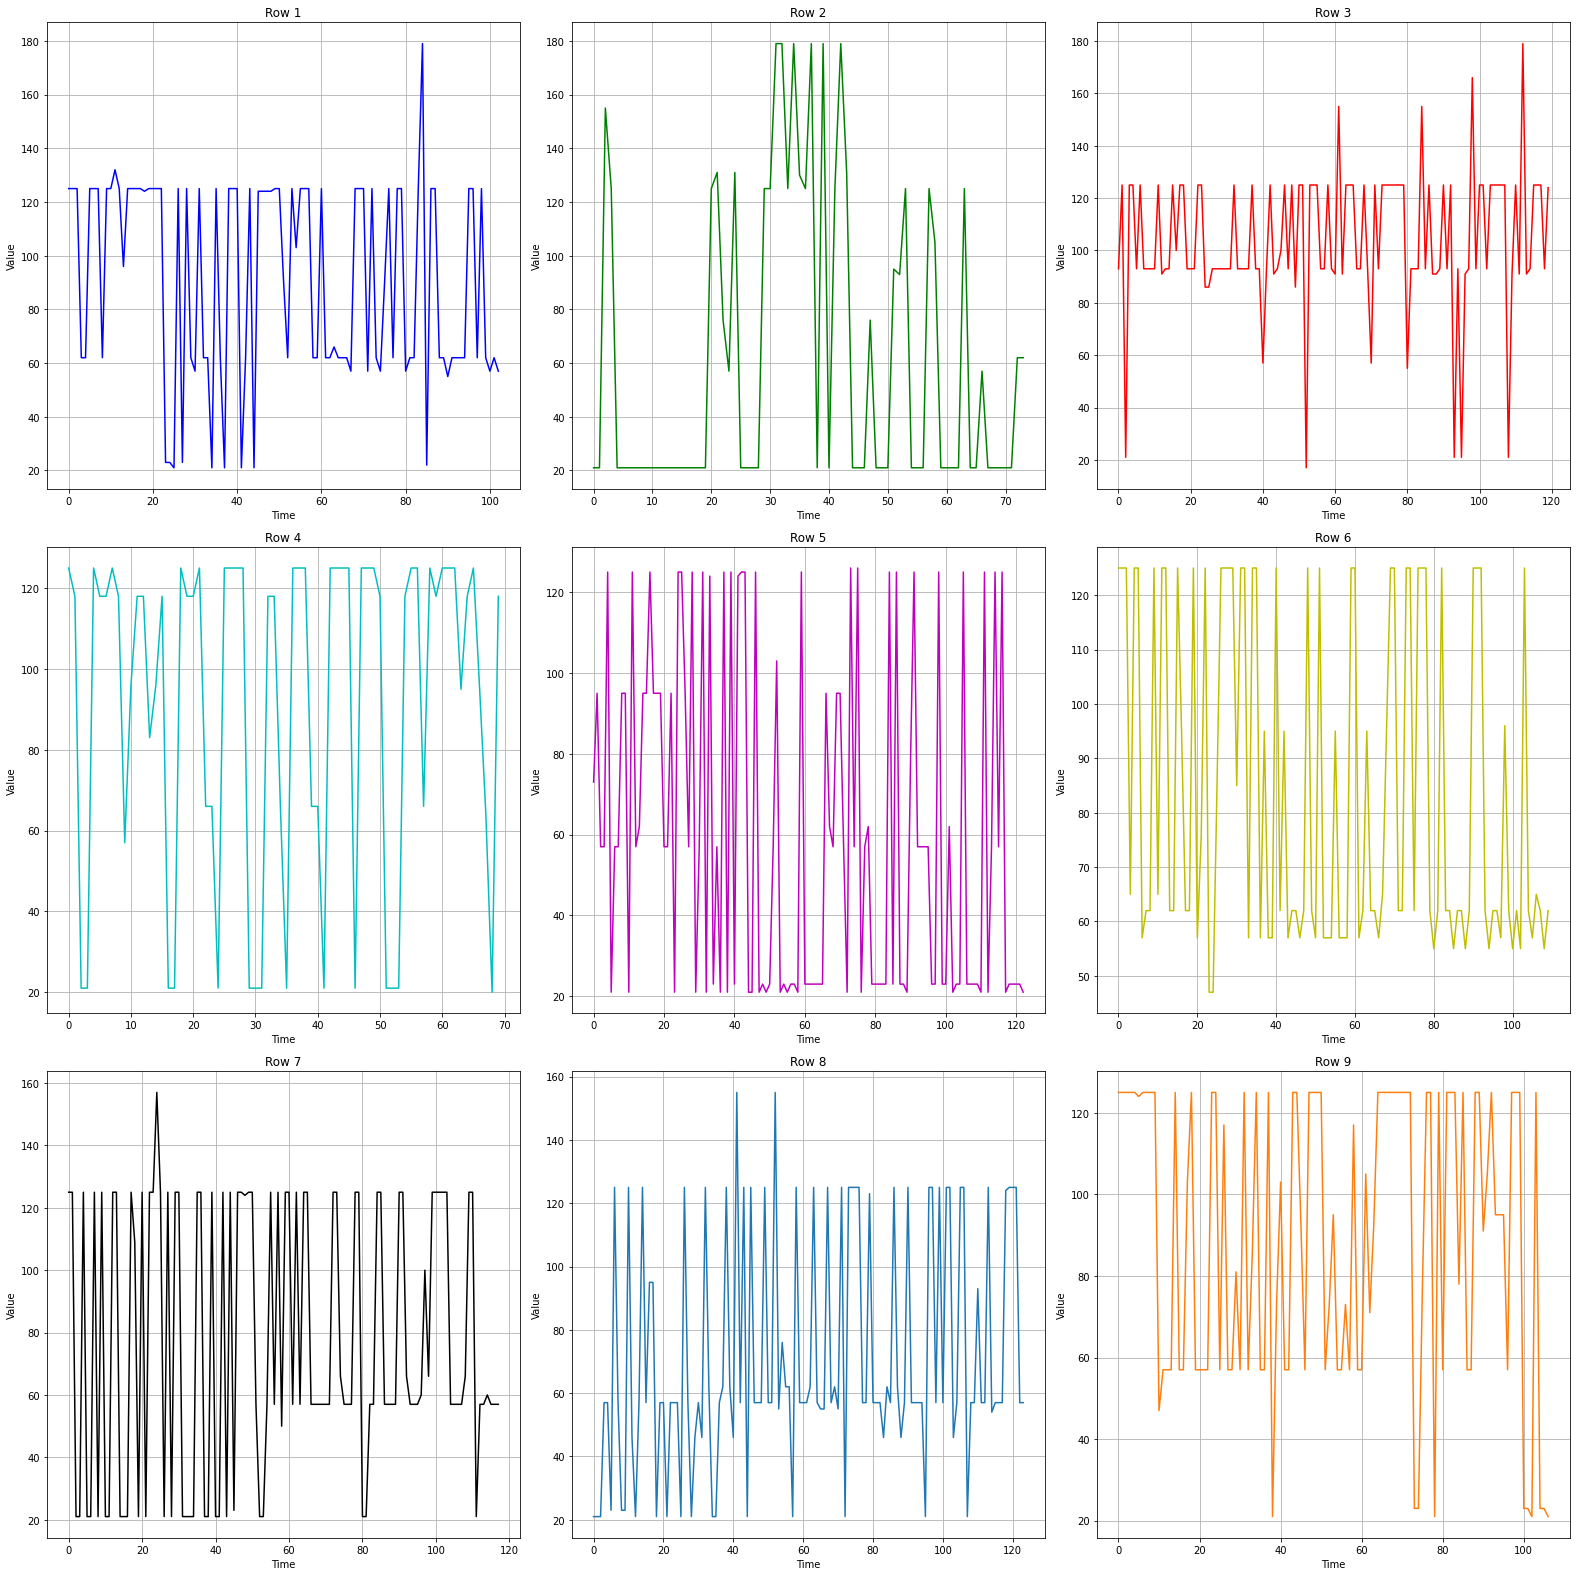

In [30]:
print("Пример распределения данных в классе 1 кластере 0")
viz_rows(ft_train['purchase_history'][(ft_train['length_class'] == 1) & (ft_train['cluster'] == 0)])

In [31]:
# Для класса 1 и кластера 0 есть минимум 55 наблюдений и максимум 570
# Таким образом, для этого класс мы можем сделать минимальный размер окна 30 и получится по 15 наборов X и Y (последовательность из 10)
# Можно брать целое число 0.7 от минимума за окно последовательности
# И далее дообучать модель на новых наборах данных по каждому пользователю
# Тем самым создавая универсальную модель для пользователей данной категории, основываясь на 40 предыдущих покупках

# Чтобы подготовить данные, нам нужно 

In [32]:
from scipy.stats import zscore
from tqdm import tqdm

def replace_outliers_by_percentile(purchase_history):
    z_scores = zscore(purchase_history)
    q_zscore = np.percentile(z_scores, 90)
    n = 0
    for i, z_score in enumerate(z_scores):
        if z_score > q_zscore:
            purchase_history[i] = np.percentile(purchase_history, 90)
            n += 1
    return n

n_changes = 0
for i in tqdm_notebook(range(len(ft_train))):
    n_changes += replace_outliers_by_percentile(ft_train['purchase_history'].iloc[i])

if n_changes > 0:
    print(f"Replaced {n_changes} outliers in train.")
    
n_changes = 0
for i in tqdm_notebook(range(len(ft_test))):
    n_changes += replace_outliers_by_percentile(ft_test['purchase_history'].iloc[i])

if n_changes > 0:
    print(f"Replaced {n_changes} outliers in test.")


  0%|          | 0/7033 [00:00<?, ?it/s]

Replaced 79770 outliers in train.


  0%|          | 0/7033 [00:00<?, ?it/s]

Replaced 80563 outliers in test.


Пример распределения данных в классе 1 кластере 0 после замены выбросов



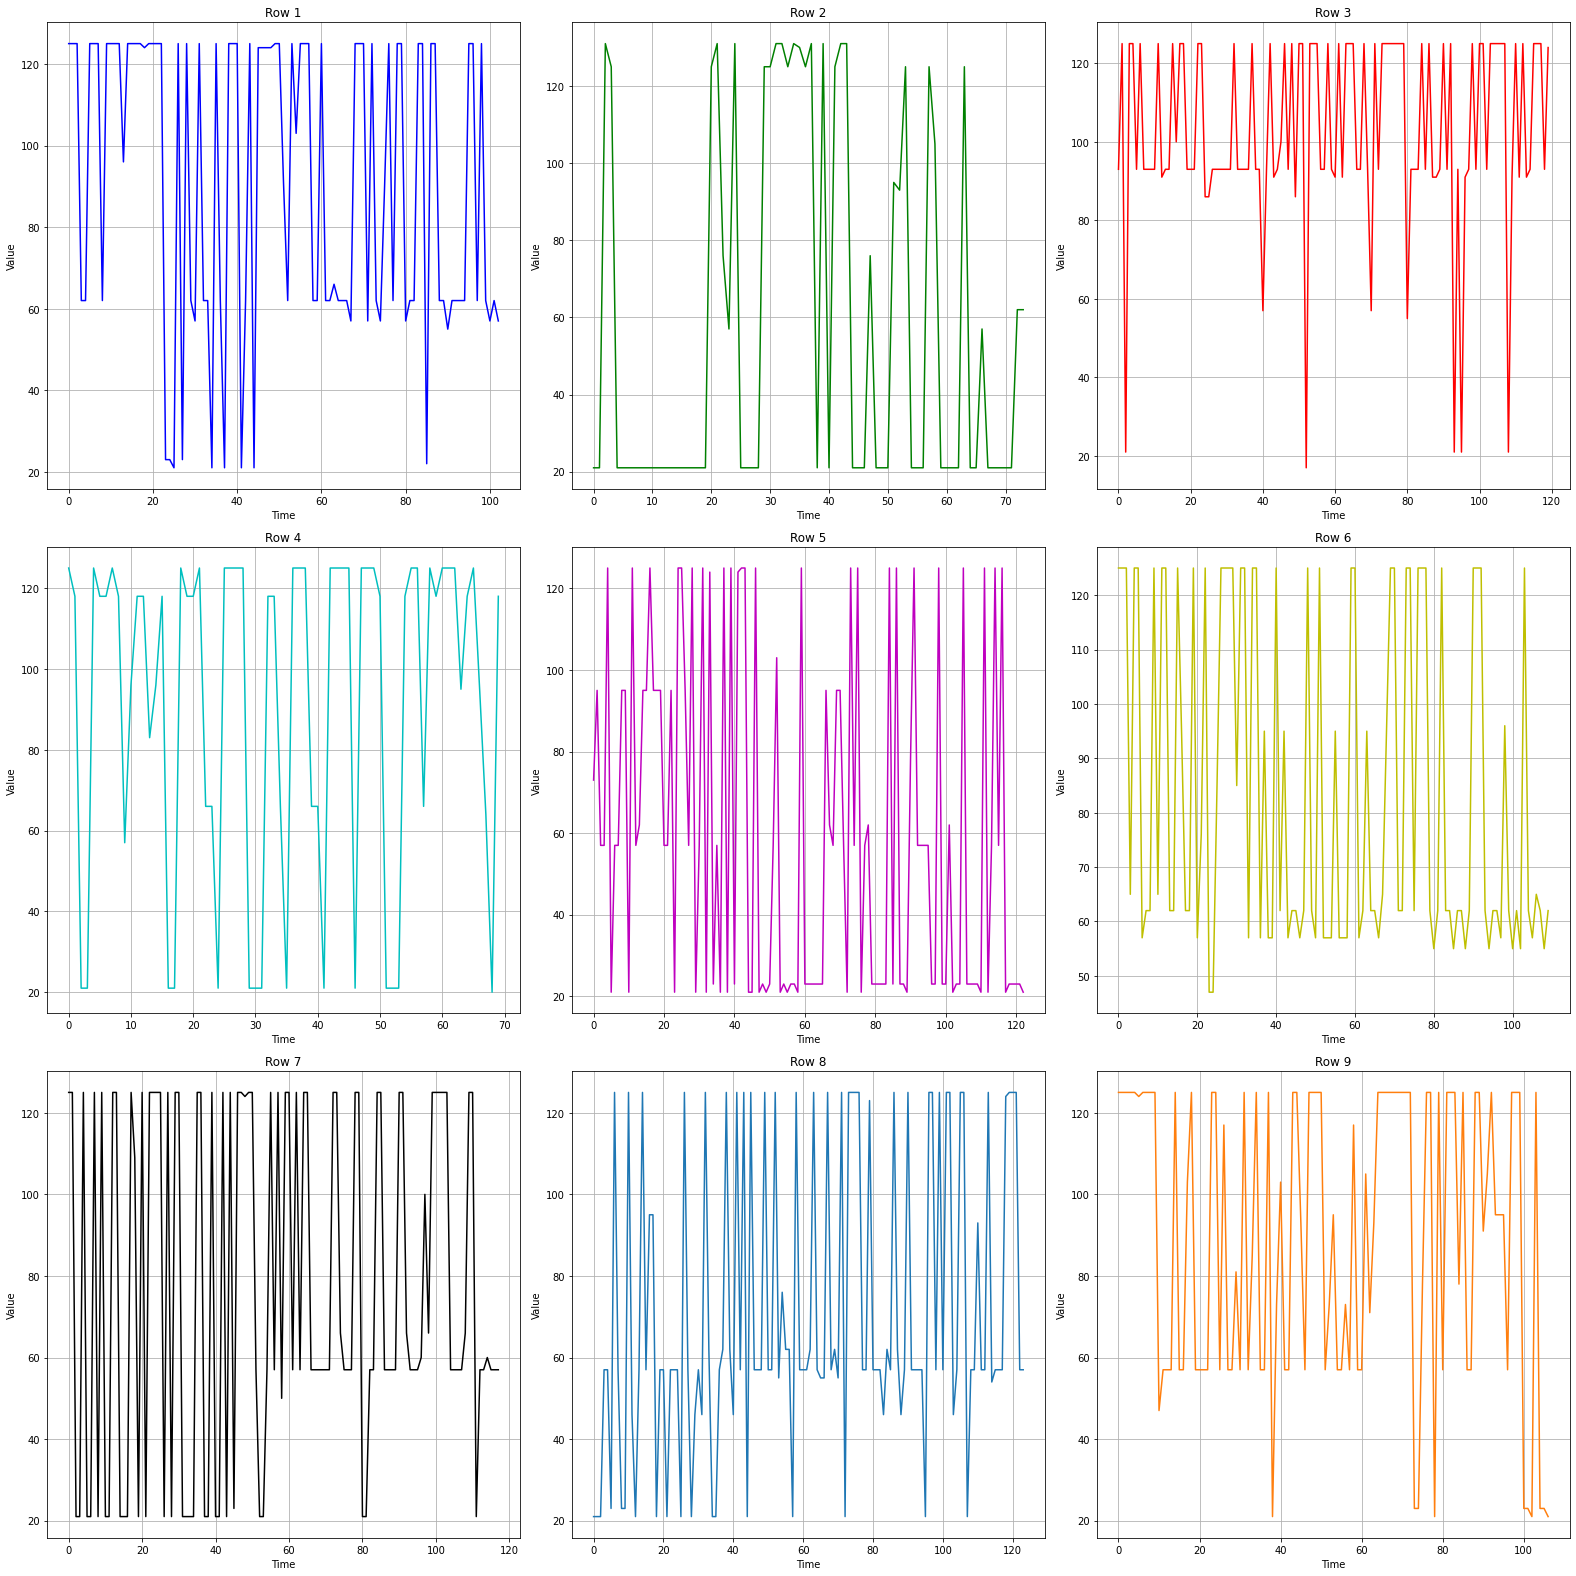

In [33]:
print("Пример распределения данных в классе 1 кластере 0 после замены выбросов\n")
viz_rows(ft_train['purchase_history'][(ft_train['length_class'] == 1) & (ft_train['cluster'] == 0)])

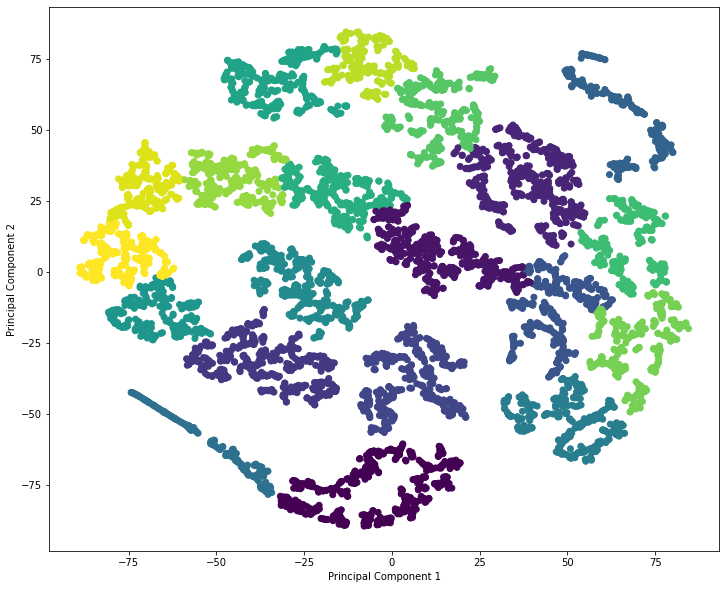

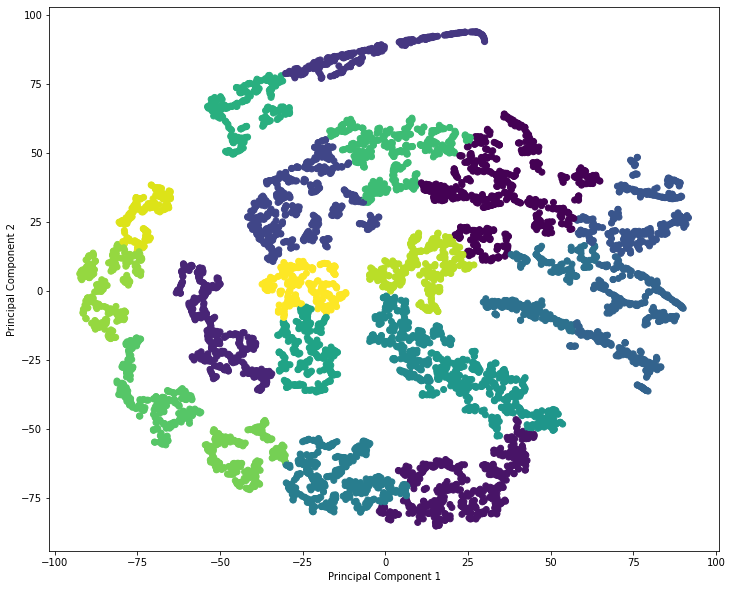

In [34]:
def create_labels(df, perplexity=20, n_clusters=20):
    dist = pd.DataFrame(euclidean_distances(df[['purchase_length', 'top_length',
                                                 'unique_length', 'count_top_codes', 'top_ratio',
                                                 'count_top_ratio', 'top_density', 'unique_density', 'purchase_ratio',
                                                 'length_class', 'mean', 'std', '25%', '50%', '75%',
                                                 'min', 'max', 'p-value']]),
                        columns=df.index, index=df.index)
    X = dist.values
    X_embedded = pd.DataFrame(TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=perplexity).fit_transform(X))
    X_embedded.index = dist.index
    X_embedded.columns = ["pc1", "pc2"]

    X1 = X_embedded.values
    clustering = Birch(n_clusters=n_clusters).fit(X1)
    df["label"] = clustering.labels_

    # Визуализация
    plt.figure(figsize=(12, 10))
    plt.scatter(X_embedded["pc1"], X_embedded["pc2"], c=df["label"])
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()
    

create_labels(ft_train)
create_labels(ft_test)

In [35]:
# def prepare_lstm_row(row):
#     sequences = []
#     features_q = []
#     features_int = []
#     target = []
#     purchase_history = row['purchase_history']
#     length = row['purchase_length']
#     window_size = int(0.7 * length)

#     if length < window_size + 10:
#         print(f"Error: sequences {row['id']} less than in + out")
#         return None

#     for i in range(length - window_size - 10):
#         sequence = purchase_history[i:i+window_size]
#         label = purchase_history[i+window_size:i+window_size+10]
#         sequences.append(sequence)
#         target.append(label)

#         feature_q_row = [
#             row['top_ratio'],
#             row['top_density'],
#             row['unique_density'],
#             row['purchase_ratio']
#         ]
#         feature_int_row = [
#             row['purchase_length'],
#             row['top_length'],
#             row['unique_length'],
#             row['count_top_codes'],
#             row['count_top_ratio'],
#             row['min'],
#             row['max'],
#             row['25%'],
#             row['75%'],
#             row['50%'],
#             row['length_class'],
#             row['cluster']
#         ]
#         features_q.append(feature_q_row)
#         features_int.append(feature_int_row)

#     return np.array(sequences), np.array(target), np.array(features_q), np.array(features_int), window_size

# def prepare_lstm_row_test(row, window_size):
#     sequences = []
#     features_q = []
#     features_int = []
#     purchase_history = row['purchase_history'][-window_size:]
    
#     feature_q_row = [
#         row['top_ratio'],
#         row['top_density'],
#         row['unique_density'],
#         row['purchase_ratio']
#     ]
    
#     feature_int_row = [
#         row['purchase_length'],
#         row['top_length'],
#         row['unique_length'],
#         row['count_top_codes'],
#         row['count_top_ratio'],
#         row['min'],
#         row['max'],
#         row['25%'],
#         row['75%'],
#         row['50%'],
#         row['length_class'],
#         row['cluster']
#     ]
    
#     sequences.append(purchase_history)
#     features_q.append(feature_q_row)
#     features_int.append(feature_int_row)

#     return np.array(sequences), np.array(features_q), np.array(features_int)



In [36]:
# from sklearn.preprocessing import MinMaxScaler

# # def normalize_and_reshape(sequences, features_q, features_int, target):
# # Нормализуем разные наборы данных
# scaler_sequences = MinMaxScaler(feature_range=(0, 1))
# sequences = scaler_sequences.fit_transform(sequences)

# scaler_target = MinMaxScaler(feature_range=(0, 1))
# target = scaler_target.fit_transform(target)

# scaler_features_q = MinMaxScaler(feature_range=(0, 1))
# features_q = scaler_features_q.fit_transform(features_q)

# scaler_features_int = MinMaxScaler(feature_range=(0, 1))
# features_int = scaler_features_int.fit_transform(features_int)

# Повторяем фичи n раз для каждой последовательности
# fea_q = sequences[:, :, np.newaxis] * features_q[:, np.newaxis, :]
# fea_int = sequences[:, :, np.newaxis] * features_int[:, np.newaxis, :]
# features_q = np.repeat(features_q[:, np.newaxis, :], sequences.shape[1], axis=1)
# features_int = np.repeat(features_int[:, np.newaxis, :], sequences.shape[1], axis=1)

#     return sequences, features_q, features_int, target

# sequences = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))
# target = target.reshape((target.shape[0], target.shape[1], 1))
# features_int = features_int.reshape((features_int.shape[0], features_int.shape[1], 1))
# features_q = features_q.reshape((features_q.shape[0], features_q.shape[1], 1))

# sequences, features_q, features_int, target = normalize_and_reshape(sequences, features_q, features_int, target)

In [37]:
# def build_lstm_model(sequences, features_q, features_int, target):
#     # Создаем входные слои
#     input_sequences = Input(shape=(sequences.shape[1], 1), name='sequences')
#     lstm_sequences = LSTM(100, activation='relu', return_sequences=True)(input_sequences)
#     encoder = LSTM(100, activation='relu', return_sequences=True)(lstm_sequences)
#     decoder = LSTM(100, activation='relu', return_sequences=True)(encoder)
#     decoder_outputs = TimeDistributed(Dense(10))(decoder)
#     model = Model(inputs=[input_sequences], outputs=decoder_outputs)
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# def fit_lstm_model(sequences, features_q, features_int, target, epochs=10, batch_size=8, validation_split=0.3):
#     model = build_lstm_model(sequences, features_q, features_int, target)
    
#     history = model.fit(
#         {'sequences': sequences},
#         target,
#         batch_size=batch_size,
#         epochs=epochs,
#         validation_split=validation_split
#     )
    
#     return model, history

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, concatenate
from sklearn.preprocessing import MinMaxScaler

def build_lstm_model(n_steps_in, n_steps_out, n_features):
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse')
    return model

def fit_lstm_model(model, X, y, epochs=30, batch_size=16):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        validation_split=0.3, verbose=2, callbacks=[early_stopping])
    
    return model, history

# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope(): 

#     # Пайплайн обучения и предсказания на каждой стрроке
#     predicted_rows = []
#     for i, row in tqdm_notebook(ft_train.iterrows(), total=len(ft_train)):
#         sequences, target, features_q, features_int, window_size = prepare_lstm_row(row)
#         scaler_sequences = MinMaxScaler(feature_range=(0, 1))
#         sequences = scaler_sequences.fit_transform(sequences)
#         min_values = scaler_sequences.data_min_
#         max_values = scaler_sequences.data_max_
#         target = scaler_sequences.fit_transform(target)
#         scaler_features_q = MinMaxScaler(feature_range=(0, 1))
#         features_q = scaler_features_q.fit_transform(features_q)
#         scaler_features_int = MinMaxScaler(feature_range=(0, 1))
#         features_int = scaler_features_int.fit_transform(features_int)
#         fea_q = sequences[:, :, np.newaxis] * features_q[:, np.newaxis, :]
#         fea_int = sequences[:, :, np.newaxis] * features_int[:, np.newaxis, :]
#         sequences = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))
#         target = target.reshape((target.shape[0], target.shape[1], 1))
#         combine = np.concatenate((sequences, fea_q, fea_int), axis=2)
#         b_model = build_lstm_model(combine.shape[1], target.shape[1], combine.shape[2])
#         model, history = fit_lstm_model(b_model, combine[-30:], target[-30:], epochs = 20)
#         sequences, features_q, features_int = prepare_lstm_row_test(ft_test.iloc[i], window_size)
#         sequences = scaler_sequences.fit_transform(sequences)
#         features_q = scaler_features_q.fit_transform(features_q)
#         features_int = scaler_features_int.fit_transform(features_int)
#         fea_q = sequences[:, :, np.newaxis] * features_q[:, np.newaxis, :]
#         fea_int = sequences[:, :, np.newaxis] * features_int[:, np.newaxis, :]
#         sequences = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))
#         target = target.reshape((target.shape[0], target.shape[1], 1))

#         combine = np.concatenate((sequences, fea_q, fea_int), axis=2)

#         predict = model.predict(combine)

#         predict = (predict[0][:, 0] * (max_values[0] - min_values[0])) + min_values[0]

#         predicted_rows.append(predict)


In [39]:
def prepare_lstm_data(data, target, min_size):
    sequences = []
    labels = []
    features_q = []
    features_int = []

    for i, row in data.iterrows():
        sequence = row['purchase_history'][-min_size:]
        label = target[target['id'] == row['id']]['purchase_history'].values[0]
        feature_q_row = [
            row['top_ratio'],
            row['top_density'],
            row['unique_density'],
            row['purchase_ratio']
        ]
        feature_int_row = [
            row['purchase_length'],
            row['top_length'],
            row['unique_length'],
            row['count_top_codes'],
            row['count_top_ratio'],
            row['min'],
            row['max'],
            row['25%'],
            row['75%'],
            row['50%'],
            row['length_class'],
            row['cluster']
        ]
        sequences.append(sequence)
        labels.append(label)
        features_q.append(feature_q_row)
        features_int.append(feature_int_row)

    return np.array(sequences), np.array(labels), np.array(features_q), np.array(features_int)


In [40]:
# Пайплайн обучения и предсказания на последней min_size последоательности по кластерам
predicted = []
# Я хочу обучать модели и предсказывать данные в зависимости от метки label 
for label in tqdm_notebook(np.unique(ft_train['label']), total = len(np.unique(ft_train['label']))):
    # а далее нужно отфильтровать данные и выбрать только те, которые подходят по метке
    filtered_data = ft_train[ft_train['label'] == label]
    filtered_target = ft_target[ft_target['id'].isin(filtered_data['id'])]
    sequences, target, features_q, features_int = prepare_lstm_data(filtered_data, filtered_target, min_size=30)
    scaler_sequences = MinMaxScaler(feature_range=(0, 1))
    sequences = scaler_sequences.fit_transform(sequences)
    min_values = scaler_sequences.data_min_
    max_values = scaler_sequences.data_max_
    target = scaler_sequences.fit_transform(target)
    scaler_features_q = MinMaxScaler(feature_range=(0, 1))
    features_q = scaler_features_q.fit_transform(features_q)
    scaler_features_int = MinMaxScaler(feature_range=(0, 1))
    features_int = scaler_features_int.fit_transform(features_int)
    fea_q = sequences[:, :, np.newaxis] * features_q[:, np.newaxis, :]
    fea_int = sequences[:, :, np.newaxis] * features_int[:, np.newaxis, :]
    sequences = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))
    target = target.reshape((target.shape[0], target.shape[1], 1))
    combine = np.concatenate((sequences, fea_q, fea_int), axis=2)
    b_model = build_lstm_model(combine.shape[1], target.shape[1], combine.shape[2])
    model, _ = fit_lstm_model(b_model, combine, target, epochs = 20)
    
    
    for i, id in enumerate(filtered_data['id']):
        filtered_test = ft_test[ft_test['id'].isin([id])]
        filtered_target = ft_target[ft_target['id'].isin([id])]
        sequences, _, features_q, features_int = prepare_lstm_data(filtered_test, filtered_target, min_size=30)
        sequences_test = scaler_sequences.fit_transform(sequences)
        features_q_test = scaler_features_q.fit_transform(features_q)
        features_int_test = scaler_features_int.fit_transform(features_int)
        fea_q_test = sequences_test[:, :, np.newaxis] * features_q_test[:, np.newaxis, :]
        fea_int_test = sequences_test[:, :, np.newaxis] * features_int_test[:, np.newaxis, :]
        sequences_test = sequences_test.reshape((sequences.shape[0], sequences.shape[1], 1))

        combine_test = np.concatenate((sequences_test, fea_q_test, fea_int_test), axis=2)

        predict = model.predict(combine_test)

        predict = (predict[0][:, 0] * (max_values[0] - min_values[0])) + min_values[0]
        
        predicted.append((id, predict))



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
23/23 - 37s - loss: 0.1054 - val_loss: 0.0717
Epoch 2/20
23/23 - 33s - loss: 0.0691 - val_loss: 0.0642
Epoch 3/20
23/23 - 32s - loss: 0.0630 - val_loss: 0.0589
Epoch 4/20
23/23 - 32s - loss: 0.0581 - val_loss: 0.0595
Epoch 5/20
23/23 - 32s - loss: 0.0576 - val_loss: 0.0575
Epoch 6/20
23/23 - 32s - loss: 0.0566 - val_loss: 0.0581
Epoch 7/20
23/23 - 32s - loss: 0.0566 - val_loss: 0.0579
Epoch 8/20
23/23 - 32s - loss: 0.0576 - val_loss: 0.0592
Epoch 9/20
23/23 - 32s - loss: 0.0569 - val_loss: 0.0583
Epoch 10/20
23/23 - 32s - loss: 0.0566 - val_loss: 0.0579
Epoch 1/20
21/21 - 34s - loss: 0.1221 - val_loss: 0.0834
Epoch 2/20
21/21 - 29s - loss: 0.0825 - val_loss: 0.0752
Epoch 3/20
21/21 - 29s - loss: 0.0749 - val_loss: 0.0674
Epoch 4/20
21/21 - 29s - loss: 0.0721 - val_loss: 0.0668
Epoch 5/20
21/21 - 29s - loss: 0.0694 - val_loss: 0.0660
Epoch 6/20
21/21 - 28s - loss: 0.0686 - val_loss: 0.0666
Epoch 7/20
21/21 - 28s - loss: 0.0689 - val_loss: 0.0656
Epoch 8/20
21/21 - 28s - loss:

In [41]:
# decoded_test_series = decode_data(encoded_test_series, {code: value for value, code in test_value_to_code.items()})

In [42]:
df = pd.DataFrame(predicted, columns=['id', 'values'])
df = df.sort_values(by='id')
df.to_csv('output.csv', index=False)

Сабмит

In [43]:
df_output = pd.read_csv('/kaggle/input/alfa-output/output.csv')
import re
df_output['values'] = df_output['values'].apply(lambda x: pd.to_numeric(x.strip('[]').split()))
df_output['values'] = df_output['values'].apply(lambda x: [round(num) for num in x])


In [44]:
def decode_data(encoded_series, code_to_value):
    def decode_list(encoded_list):
        return [code_to_value[code] for code in encoded_list]
    decoded_series = encoded_series.apply(decode_list)

    return decoded_series

In [45]:
df_output1 = df_output.copy()

In [46]:
df_output1

,id,values
0,1,"[31, 37, 38, 38, 37, 37, 36, 36, 35, 35]"
1,2,"[40, 46, 49, 50, 50, 50, 50, 50, 49, 49]"
2,3,"[30, 35, 37, 37, 37, 37, 37, 36, 36, 36]"
3,4,"[40, 46, 46, 46, 46, 46, 47, 47, 47, 47]"
4,5,"[35, 42, 44, 44, 44, 43, 43, 43, 43, 43]"
...,...,...
7028,7029,"[31, 35, 36, 36, 36, 36, 36, 36, 36, 36]"
7029,7030,"[32, 37, 40, 40, 40, 40, 40, 40, 40, 40]"
7030,7031,"[46, 56, 62, 66, 68, 69, 70, 70, 70, 70]"
7031,7032,"[31, 37, 38, 38, 37, 37, 36, 36, 35, 35]"


1 Подход

In [47]:
df_output['values'] = decode_data(df_output['values'], {code: value for value, code in test_value_to_code.items()})
df_output

,id,values
0,1,"[5065, 5111, 5122, 5122, 5111, 5111, 5099, 509..."
1,2,"[5137, 5200, 5251, 5261, 5261, 5261, 5261, 526..."
2,3,"[5047, 5094, 5111, 5111, 5111, 5111, 5111, 509..."
3,4,"[5137, 5200, 5200, 5200, 5200, 5200, 5211, 521..."
4,5,"[5094, 5172, 5193, 5193, 5193, 5192, 5192, 519..."
...,...,...
7028,7029,"[5065, 5094, 5099, 5099, 5099, 5099, 5099, 509..."
7029,7030,"[5072, 5111, 5137, 5137, 5137, 5137, 5137, 513..."
7030,7031,"[5200, 5399, 5499, 5541, 5571, 5599, 5611, 561..."
7031,7032,"[5065, 5111, 5122, 5122, 5111, 5111, 5099, 509..."


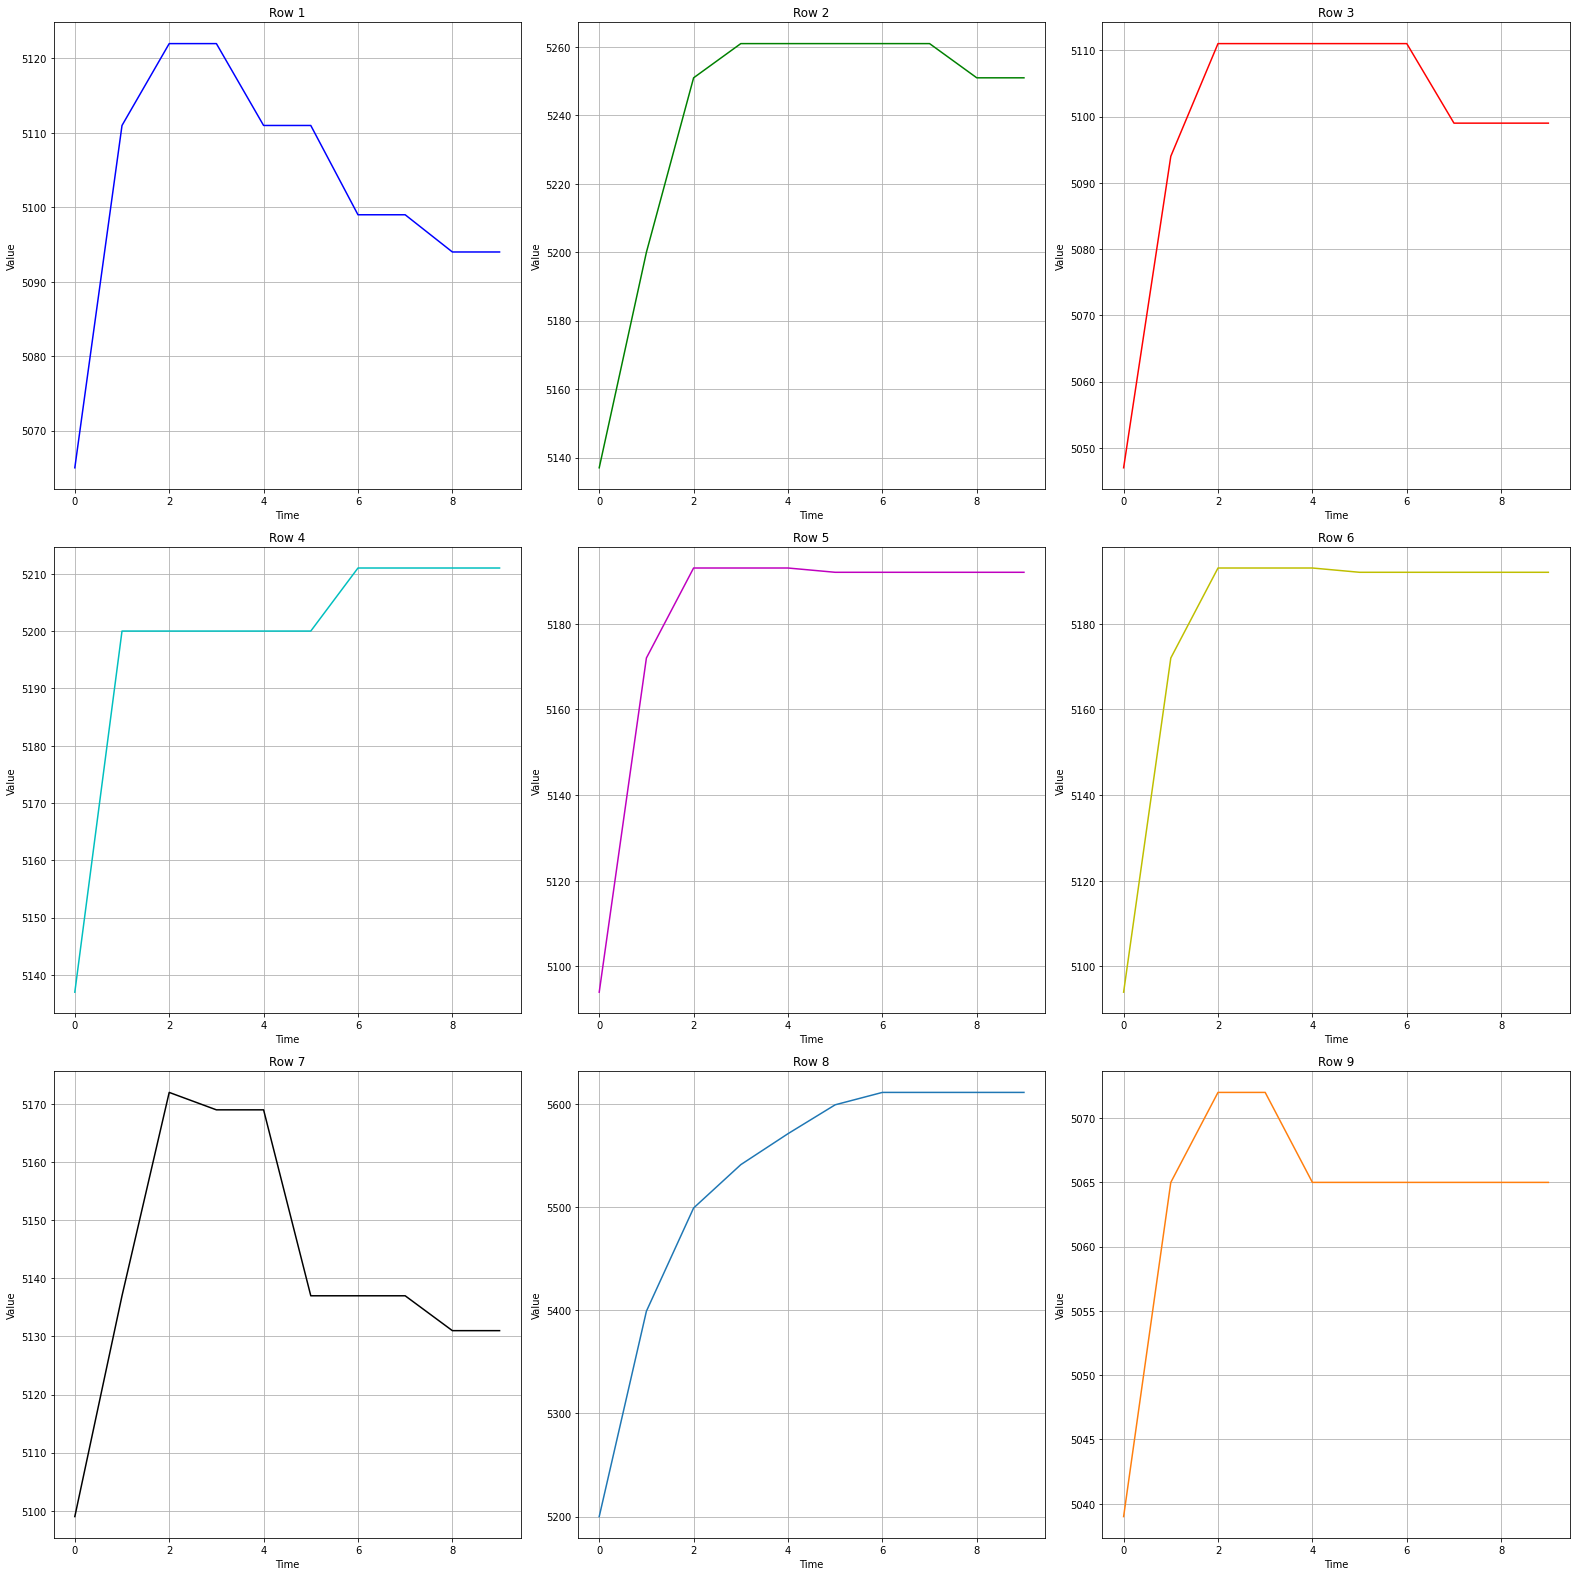

In [48]:
viz_rows(df_output['values'])

In [49]:
df_output.columns = ['Id', 'Predicted']
df_output['Predicted'] = df_output.Predicted.astype(str).str.replace(',', '')
df_output['Id'] = df_output.index
df_output.to_csv('submission_1.csv', index=False)

2 подход

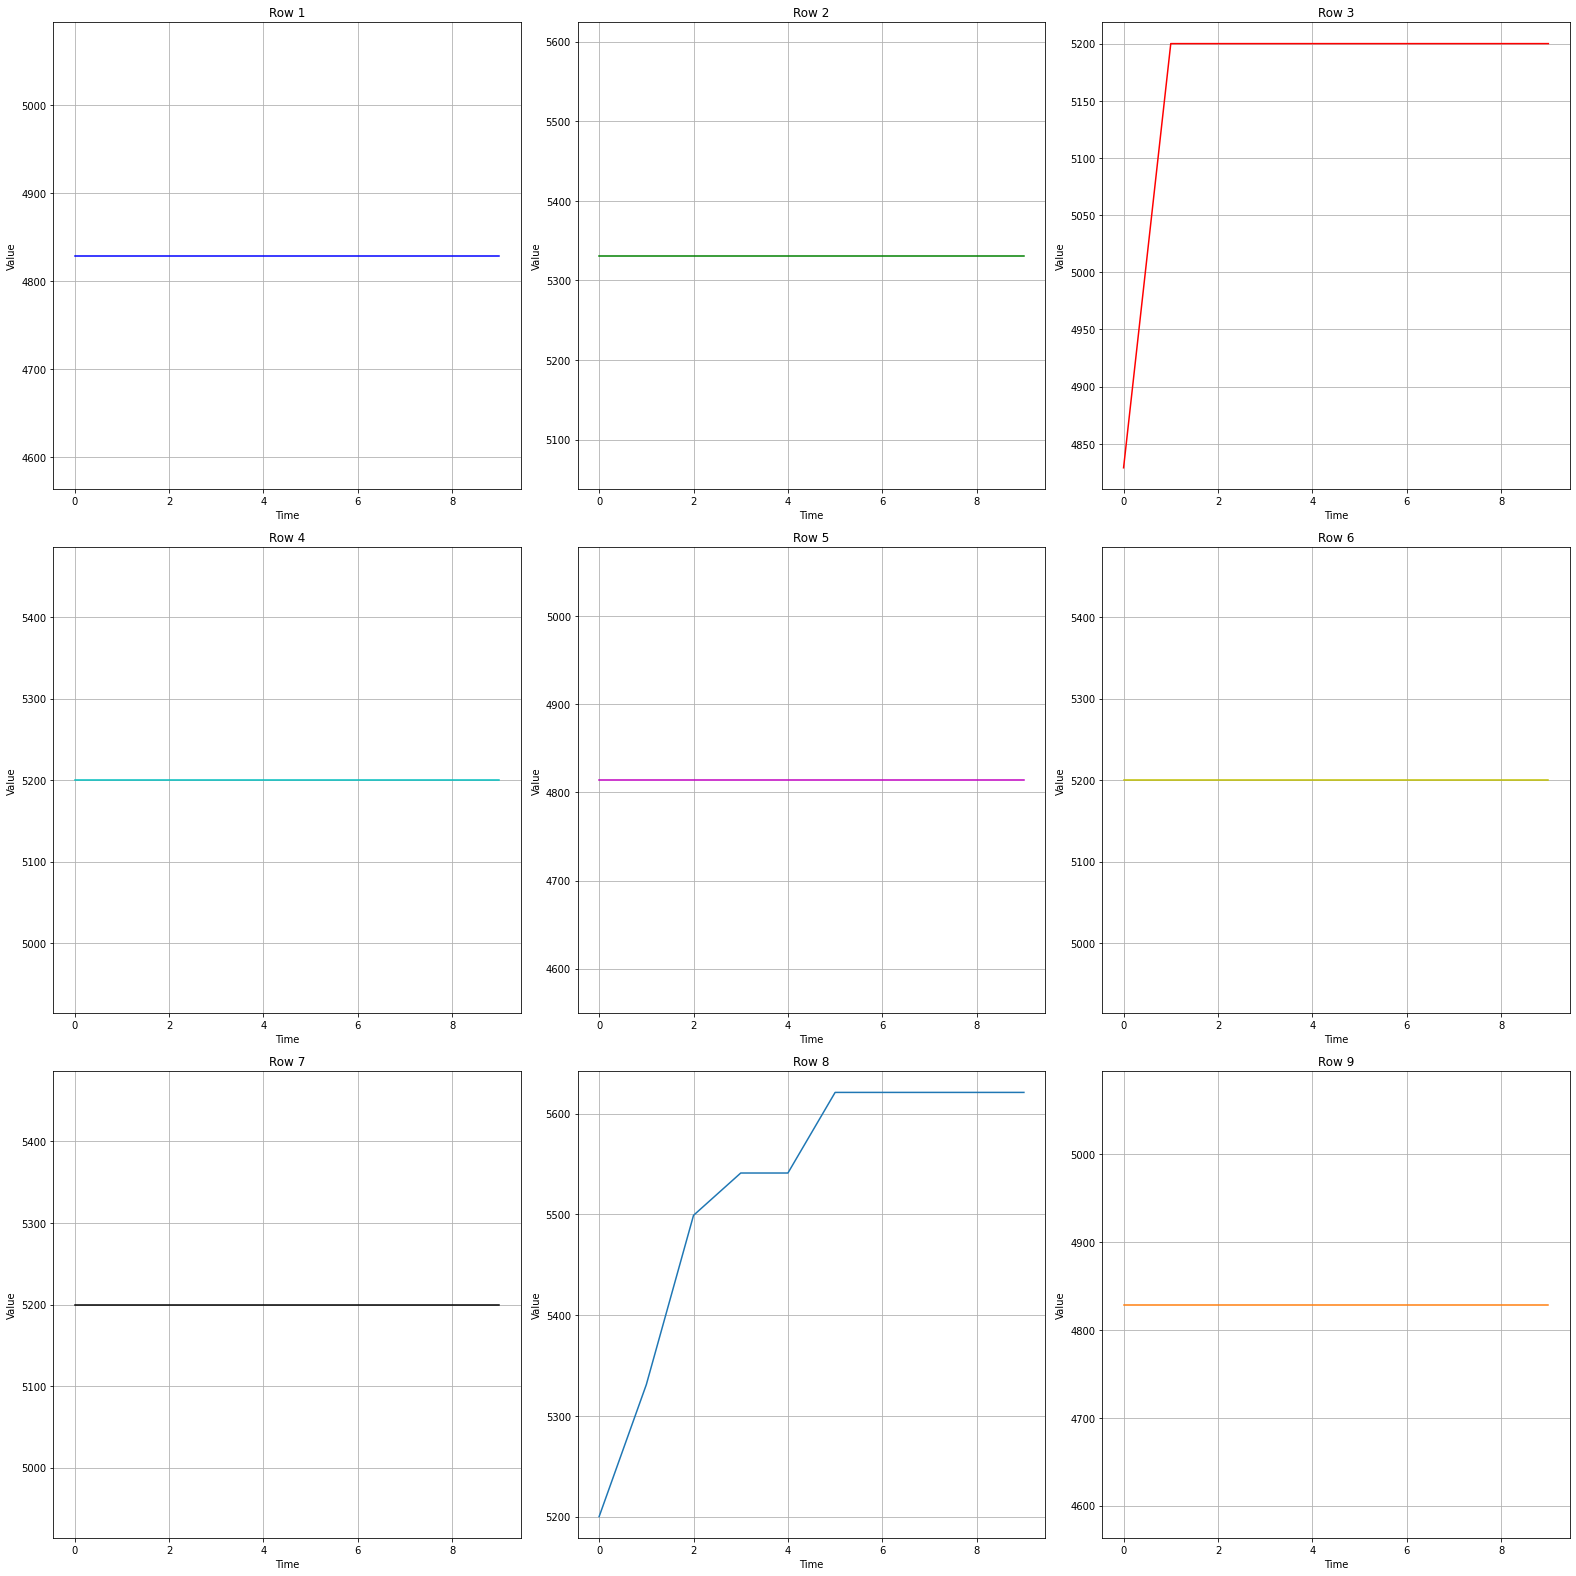

In [50]:
def map_to_nearest_values(series, reference_values):
    series_array = series.to_numpy()
    reference_array = np.array(reference_values)
    indices = np.abs(series_array[:, np.newaxis] - reference_array).argmin(axis=1)
    nearest_values = reference_array[indices]
    return pd.Series(nearest_values)

for i, row in df_output1.iterrows():
    list_pred = list(map_to_nearest_values(pd.Series(row['values']), pd.Series(ft_test['unique_codes'][i])))
    df_output1.at[i, 'values'] = list_pred
    
df_output1['values'] = decode_data(df_output1['values'], {code: value for value, code in test_value_to_code.items()})

df_output1.columns = ['Id', 'Predicted']
viz_rows(df_output1['Predicted'])
df_output1['Predicted'] = df_output1.Predicted.astype(str).str.replace(',', '')
df_output1['Id'] = df_output1.index
df_output1.to_csv('submission_2.csv', index=False)

In [51]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector
# from tensorflow.keras.models import Model

# def build_lstm_model(sequences, features_q, features_int, target):
#     # Создаем входные слои
#     input_sequences = Input(shape=(sequences.shape[1], 1), name='sequences')
#     lstm_sequences = LSTM(100, activation='relu', return_sequences=True)(input_sequences)
#     encoder = LSTM(100, activation='relu', return_sequences=True)(lstm_sequences)
#     decoder = LSTM(100, activation='relu', return_sequences=True)(encoder)
#     decoder_outputs = TimeDistributed(Dense(10))(decoder)
#     model = Model(inputs=[input_sequences], outputs=decoder_outputs)
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# def fit_lstm_model(sequences, features_q, features_int, target, epochs=10, batch_size=32, validation_split=0.1):
#     model = build_lstm_model(sequences, features_q, features_int, target)
    
#     history = model.fit(
#         {'sequences': sequences},
#         target,
#         batch_size=batch_size,
#         epochs=epochs,
#         validation_split=validation_split
#     )
    
#     return model, history

# # Пример использования
# model, history = fit_lstm_model(sequences, features_q, features_int, target)